This notebook provides the plotting functions for Figure 3 a-f. It also includes the warping function used to transform the chirp response in Figure 2e. The warping is achieved using isotonic regression.

In [1]:
%matplotlib inline

import GPy
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import beta
from sklearn.isotonic import IsotonicRegression
import tqdm

from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *

sns.set_style('white')

# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True}) # ?

directories = json.load(open('directories.json'))

In [2]:
data_linear = load_hdf5(directories['data'] + 'SMP_M1_RR2_BC2_ChirpI.h5')

data_df = pd.read_csv(directories['data'] + 'SMP_M1_RR2_BC2_ChirpI.csv', index_col = 0)
data_df = data_df.groupby(['roi', 'frame']).mean().reset_index()
trial_duration = data_df['x_t'].max() / 2

In [3]:
chirp_stimulus = h5py.File(directories['misc'] + 'chirp.h5', 'r')['chirp'][:]

chirp_stimulus -= chirp_stimulus.mean()
chirp_stimulus /= chirp_stimulus.std()

chirp_tpnts = np.linspace(0, trial_duration, chirp_stimulus.shape[0])

In [4]:
def rbf_func(tpnts, l, sigma, v = 2):
    
    euc_dist_sqr = np.abs(- tpnts[:, None]) ** v
    sqr_dist_scale = euc_dist_sqr / (2 * l ** v)
    rbf_out = sigma * np.exp(-sqr_dist_scale)
    
    return rbf_out[:, 0]

In [5]:
n_anchors = 512
slice_width = 0.25
anchors = np.linspace(0, trial_duration, n_anchors)

In [6]:
slices = []

slice_length = 64
fit_stack = np.zeros([slice_length, n_anchors])
par_stack = np.zeros([2, n_anchors]) 
new_tpnts = np.linspace(-slice_width, slice_width, slice_length)

p0 = [0.1, 100]

slice_list = []
tpnts_list = []

for itx, anchor_point in enumerate(anchors):
    start = anchor_point - slice_width
    stop = anchor_point + slice_width
    anchor_mask = (chirp_tpnts > start) & (chirp_tpnts < stop)
    
    trace_slice = chirp_stimulus[anchor_mask]
    tpnts_slice = chirp_tpnts[anchor_mask]
    
    y_distance = np.correlate(trace_slice, trace_slice, mode = 'same')
    x_distance = np.linspace(-slice_width, slice_width, y_distance.shape[0])
    
    slice_list.append(y_distance)
    
    popt, pcov = curve_fit(rbf_func, x_distance, y_distance, p0 = p0)
    par_stack[:, itx] = popt 
    fit_stack[:, itx] = rbf_func(new_tpnts, popt[0], popt[1])
    
par_stack[0, :] = np.abs(par_stack[0, :])

In [7]:
par_cdf = np.cumsum(np.power(par_stack[0, :], -1))
par_cdf -= par_cdf.min()
par_cdf /= par_cdf.max()
par_cdf *= 32

par_length = par_stack.shape[1]
par_tpnts = np.linspace(0, trial_duration, par_stack.shape[1])
new_cdf = np.linspace(0, trial_duration, par_tpnts.shape[0])
cdf_transformed = IsotonicRegression().fit_transform(par_cdf, par_tpnts)

iso_reg = IsotonicRegression()
iso_reg.fit(par_tpnts, par_cdf)
x_ = iso_reg.transform(chirp_tpnts)

In [8]:
roi = np.unique(data_df['roi'])[0]

data_df = data_df.sort_values(by = 'x_t')

y = data_df[data_df['roi'] == roi]['y']
x_t = data_df[data_df['roi'] == roi]['x_t']

global_mask = x_t < trial_duration
local_mask = x_t > trial_duration

x_t_local = x_t[local_mask]
x_t_local -= trial_duration
y_local = y[local_mask]

x_t_global = x_t[global_mask]
y_global = y[global_mask]

x_new_local = iso_reg.transform(x_t_local)
x_new_global = iso_reg.transform(x_t_global)

x_predict = np.linspace(0, trial_duration, 33 * 50)
x_predict_warp = iso_reg.transform(x_predict)

Warp Files

Plots

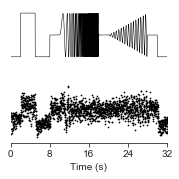

In [9]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

offset = 5

stimulus_tpnts = np.linspace(0, 32, chirp_stimulus.shape[0])
ax.plot(stimulus_tpnts, chirp_stimulus, c = 'k', linewidth = 0.5)

ax.scatter(x_t_local, y_local - offset, s = 0.5, c = 'k')

sns.despine(left = True, ax = ax)
ax.set_yticklabels([]);

ax.set_xlim(0, 32);

ax.set_xlabel('Time (s)', fontsize=10);
plt.xticks([0, 8, 16, 24, 32])
ax.get_yaxis().set_visible(False)
plt.tick_params(axis='both', which='major', labelsize = 'medium')

fig.set_size_inches(2.8, 2.5)

plt.savefig(directories['figs'] + 'warping/' + 'chirp_stimulus.svg', dpi = 300)

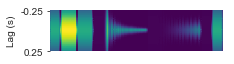

In [10]:
sns.set_style('ticks')

hmap_p = {
#     'square': True, 
    'cmap': 'viridis',
    'xticklabels': False,
    'yticklabels': False,
    'cbar': False,
}

fig, ax = plt.subplots(1)
sns.heatmap(fit_stack, ax = ax, **hmap_p)
plt.yticks([1, 64])
ax.set_yticklabels([-0.25, 0.25]);
ax.set_ylabel('Lag (s)', fontsize=10, clip_on = False);

plt.tick_params(axis='both', which='major', labelsize = 'medium')

fig.set_size_inches(3.35, 1)

plt.tight_layout()

plt.savefig(directories['figs'] + 'warping/' + 'heatmap_fitted_acf.png', dpi = 600)

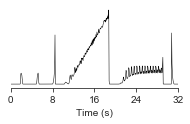

In [11]:
par_cdf_rescale = np.power(par_stack[0, :], -1).max() / 32
par_cdf_offset = np.power(par_stack[0, :], -1).max()

fig, ax = plt.subplots(1)

ax.plot(par_tpnts, np.power(par_stack[0, :], -1), 
           c = 'k', alpha = 1, label = '1 / Lengthscale', linewidth = 0.5)

# ax.plot(par_tpnts, par_cdf * par_cdf_rescale + par_cdf_offset, c = 'b', linewidth = 0.5, label = 'Cumulative')

ax.set_yticklabels([]);
ax.set_xlim(0, 32)
ax.set_xlabel('Time (s)', fontsize=10);
plt.xticks([0, 8, 16, 24, 32])
ax.get_yaxis().set_visible(False)
plt.tick_params(axis='both', which='major', labelsize = 'medium')
sns.despine(left = True, ax = ax)

fig.set_size_inches(3, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'acf_parameters.svg', dpi = 300)

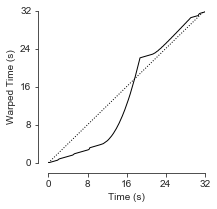

In [12]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(par_tpnts, par_cdf, color = 'k', linewidth = 1)
ax.plot(par_tpnts, par_tpnts, color = 'k', linewidth = 1, linestyle = ':')

plt.xticks([0, 8, 16, 24, 32])
plt.yticks([0, 8, 16, 24, 32])
ax.set_xlim(0, 32)
ax.set_ylim(0, 32)
ax.set_xlabel('Time (s)', fontsize=10)
ax.set_ylabel('Warped Time (s)', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize='medium')
sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2.8, 2.8)

plt.savefig(directories['figs'] + 'warping/' + 'time_vs_warpedtime.svg', dpi = 300)

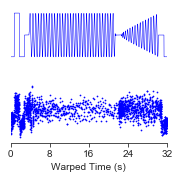

In [13]:
fig, ax = plt.subplots(1)

offset = 5

ax.plot(x_, chirp_stimulus, color = 'b', linewidth = 0.5)

ax.scatter(x_new_local, y_local - offset, s = 0.5, c = 'b')

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Warped Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)

sns.despine(left = True, ax = ax)
fig.set_size_inches(2.8, 2.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_stimulus.svg', dpi = 300)

In [14]:
m1 = GPy.models.SparseGPRegression(
    x_t_global[:, None],
    y_global[:, None],
    kernel = GPy.kern.RBF(1),
    num_inducing = 300
)

m1.optimize_restarts(4, max_iters = 25, messages = False)
# m1.plot()

Optimization restart 1/4, f = 875.2641336899069
Optimization restart 2/4, f = 1664.0885457398826
Optimization restart 3/4, f = 1631.6030064671177
Optimization restart 4/4, f = 1769.301044275827


In [15]:
m2 = GPy.models.SparseGPRegression(
    x_new_global[:, None],
    y_global[:, None],
    kernel = GPy.kern.RBF(1),
    num_inducing = 300
)

m2.optimize_restarts(4, max_iters = 25, messages = False)
# m2.plot()

Optimization restart 1/4, f = 991.4592219366909
Optimization restart 2/4, f = 1576.5161802695957
Optimization restart 3/4, f = 1576.359795070003
Optimization restart 4/4, f = 1577.2033528743823


In [16]:
m3 = GPy.models.SparseGPRegression(
    x_new_local[:, None],
    y_local[:, None],
    kernel = GPy.kern.RBF(1),
    num_inducing = 300
)

m3.optimize_restarts(4, max_iters = 25, messages = False)
# m3.plot()

Optimization restart 1/4, f = 1077.9209792314953
Optimization restart 2/4, f = 1599.354746936626
Optimization restart 3/4, f = 1599.5292113531202
Optimization restart 4/4, f = 1600.3959449592473


In [17]:
m1_mu, m1_sig = m1.predict(x_predict[:, None], include_likelihood = False)
m1_mu, m1_sig_outer = m1.predict(x_predict[:, None], include_likelihood = True)

m2_mu, m2_sig = m2.predict(x_predict_warp[:, None], include_likelihood = False)
m2_mu, m2_sig_outer = m2.predict(x_predict_warp[:, None], include_likelihood = True)

m3_mu, m3_sig = m3.predict(x_predict_warp[:, None], include_likelihood = False)
m3_mu, m3_sig_outer = m3.predict(x_predict_warp[:, None], include_likelihood = True)

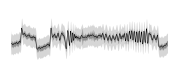

In [18]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.plot(x_predict, m1_mu, color = 'k', linewidth = 0.5)
upper, lower = compute_bounds(m1_mu, m1_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.33)
upper, lower = compute_bounds(m1_mu, m1_sig_outer, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

ax.set_xlim(0, 32)
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_yticklabels([]);
ax.set_xticklabels([]);
ax.set_ylim(-3, 3)
ax.set_aspect(2)
sns.despine(left = True, bottom = True, ax = ax)

fig.set_size_inches(2.8, 1.5)

# plt.savefig(directories['figs'] + 'warping/' + 'raw_gp.svg', dpi = 300)

In [19]:
n_samples = 5
mu_post = m1.posterior_samples_f(x_predict[:, None], size = n_samples)

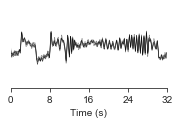

In [20]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

sample_colors = sns.color_palette('hls', n_samples)

offset = 0

for itx in range(n_samples):
    ax.plot(x_predict, mu_post[:, 0, itx] + itx * offset, color = 'k', alpha = 0.5, linewidth = 0.5)
    
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
ax.set_ylim(-3, 3)
sns.despine(ax = ax, left = True)

fig.set_size_inches(2.8, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'raw_gp_samples.svg', dpi = 300)

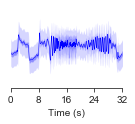

In [21]:
fig, ax = plt.subplots(1)

ax.plot(x_predict, m2_mu, color = 'b', linewidth = 0.5)
upper, lower = compute_bounds(m2_mu, m2_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'b', alpha = 0.33)
upper, lower = compute_bounds(m2_mu, m2_sig_outer, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'b', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_gp_global.svg', dpi = 300)

In [22]:
n_samples = 5
mu_post = m2.posterior_samples_f(x_predict_warp[:, None], size = n_samples)

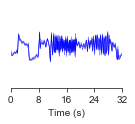

In [23]:
fig, ax = plt.subplots(1)

sample_colors = sns.color_palette('hls', n_samples)

offset = 0

for itx in range(n_samples):
    ax.plot(x_predict, mu_post[:, 0, itx] + itx * offset, color = 'b', alpha = 0.5, linewidth = 0.5)
    
ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_gp_samples.svg', dpi = 300)

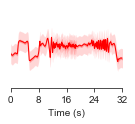

In [24]:
fig, ax = plt.subplots(1)

ax.plot(x_predict, m3_mu, color = 'r', linewidth = 1)
upper, lower = compute_bounds(m3_mu, m3_sig, n_sigma = 2)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'r', alpha = 0.33)
upper, lower = compute_bounds(m3_mu, m3_sig_outer, n_sigma = 2)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = 'r', alpha = 0.16)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'warped_gp_local.svg', dpi = 300)

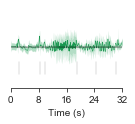

In [25]:
fig, ax = plt.subplots(1)

ax.plot(x_predict, m2_mu - m3_mu, color = '#1a9850', linewidth = 0.5)
ax.plot(x_predict, np.zeros(x_predict.shape), color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(m2_mu - m3_mu, m2_sig + m3_sig, n_sigma = 3)
ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.33)

diff_mask = (upper < 0) | (lower > 0)

# upper, lower = compute_bounds(m2_mu - m3_mu, m2_sig_outer + m3_sig_outer, n_sigma = 3)
# ax.fill_between(x_predict, upper[:, 0], lower[:, 0], facecolor = '#1a9850', alpha = 0.16)

y_min = - 1

ax.fill_between(
    x_predict, 
    np.ones(x_predict.shape) * 2 * y_min, 
    np.ones(x_predict.shape) * y_min, 
    where = diff_mask[:, 0], 
    facecolor = 'k', 
    alpha = 0.16
)

ax.set_xlim(0, 32)
plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)
ax.set_yticklabels([]);
ax.get_yaxis().set_visible(False)
sns.despine(ax = ax, left = True)
ax.set_ylim(-3, 3)

fig.set_size_inches(2, 1.5)

plt.savefig(directories['figs'] + 'warping/' + 'diff_gp.svg', dpi = 300)

In [26]:
n_sigma = np.linspace(0, 10, 200)

n_blob_inner = np.zeros(n_sigma.shape[0])
n_blob_outer = np.zeros(n_sigma.shape[0])

In [27]:
from scipy.ndimage import label

for itx, sigma in enumerate(n_sigma):
    # Compute inner EC
    upper, lower = compute_bounds(m2_mu - m3_mu, m2_sig + m3_sig, n_sigma = sigma)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_inner[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

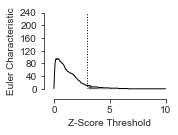

In [28]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n_blob_inner, color = 'k', linewidth = 1, clip_on = False)
ax.plot(np.ones(240) * 3, np.arange(240), color = 'k', linewidth = 1, linestyle = ':')

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_inner[sigma_mask],
    facecolor = 'k', 
    alpha = 0.66,
    clip_on = False
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 240)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 5))
plt.yticks(np.arange(0, 280, 40))

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 1.4)

plt.savefig(directories['figs'] + 'warping/' + 'zscore_vs_ec.svg', dpi = 300)

Approximate Null-Distribution

i. pool all observations

ii. randomly assign 300 points from this pool to each of two groups (repeat x times)

iii. fit GP each group

iv. compute EC for different values of sigma

In [67]:
y_pool = np.hstack([y_local, y_global])
x_new_pool = np.hstack([x_new_local, x_new_global])

n_bootstrap = 500
n_samples = 300

array_shape = [n_bootstrap, x_predict.shape[0]]
mB1_mu, mB1_sig = np.zeros(array_shape), np.zeros(array_shape)
mB2_mu, mB2_sig = np.zeros(array_shape), np.zeros(array_shape)

for itx in tqdm.tqdm(range(n_bootstrap)):
    np.random.seed(itx)
    
    all_boot_samples = np.random.choice(y_pool.shape[0], n_samples * 2, replace = False)
    
    B1_samples = all_boot_samples[:n_samples]
    B2_samples = all_boot_samples[n_samples:]
    
    # Bootstrap 1
    mB1 = GPy.models.GPRegression(
        x_new_pool[B1_samples, None],
        y_pool[B1_samples, None],
        kernel = GPy.kern.RBF(1),
    )

    mB1.optimize_restarts(1, max_iters = 25, verbose = False)

    mB1_mu_temp, mB1_sig_temp = mB1.predict(x_predict[:, None], include_likelihood = False)
    mB1_mu[itx, :] = mB1_mu_temp[:, 0]
    mB1_sig[itx, :] = mB1_sig_temp[:, 0]
    
    # Bootstrap 2
    mB2 = GPy.models.GPRegression(
        x_new_pool[B2_samples, None],
        y_pool[B2_samples, None],
        kernel = GPy.kern.RBF(1),
    )

    mB2.optimize_restarts(1, max_iters = 25, verbose = False)

    mB2_mu_temp, mB2_sig_temp = mB2.predict(x_predict[:, None], include_likelihood = False)
    mB2_mu[itx, :] = mB2_mu_temp[:, 0]
    mB2_sig[itx, :] = mB2_sig_temp[:, 0]

n_blob_bootstrap = np.zeros([n_bootstrap, n_sigma.shape[0]])

for ity in tqdm.tqdm(range(n_bootstrap)):
    for itx, sigma in enumerate(n_sigma):
        upper, lower = compute_bounds(mB1_mu[ity, :] - mB2_mu[ity, :], mB1_sig[ity, :] + mB2_sig[ity, :], n_sigma = sigma)

        diff_mask = (upper < 0) | (lower > 0)

        n_blob_bootstrap[ity, itx] = np.unique(np.hstack(label(diff_mask)[0])).max()



  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:01<12:52,  1.55s/it]

  0%|          | 2/500 [00:03<12:46,  1.54s/it]

  1%|          | 3/500 [00:04<12:50,  1.55s/it]

  1%|          | 4/500 [00:05<12:04,  1.46s/it]

  1%|          | 5/500 [00:07<11:34,  1.40s/it]

  1%|          | 6/500 [00:08<12:30,  1.52s/it]

  1%|▏         | 7/500 [00:10<11:26,  1.39s/it]

  2%|▏         | 8/500 [00:11<10:42,  1.31s/it]

  2%|▏         | 9/500 [00:12<11:31,  1.41s/it]

  2%|▏         | 10/500 [00:14<11:51,  1.45s/it]

  2%|▏         | 11/500 [00:15<11:38,  1.43s/it]

  2%|▏         | 12/500 [00:17<11:48,  1.45s/it]

  3%|▎         | 13/500 [00:18<11:52,  1.46s/it]

  3%|▎         | 14/500 [00:20<11:54,  1.47s/it]

  3%|▎         | 15/500 [00:21<10:56,  1.35s/it]

  3%|▎         | 16/500 [00:22<11:00,  1.37s/it]

  3%|▎         | 17/500 [00:23<10:40,  1.33s/it]

  4%|▎         | 18/500 [00:25<10:49,  1.35s/it]

  4%|▍         | 19/500 [00:26<11:04,  1.38s/it]

  4%|▍         |

 28%|██▊       | 139/500 [07:20<23:18,  3.87s/it]

 28%|██▊       | 140/500 [07:23<21:40,  3.61s/it]

 28%|██▊       | 141/500 [07:27<21:45,  3.64s/it]

 28%|██▊       | 142/500 [07:30<21:12,  3.56s/it]

 29%|██▊       | 143/500 [07:33<19:56,  3.35s/it]

 29%|██▉       | 144/500 [07:36<19:19,  3.26s/it]

 29%|██▉       | 145/500 [07:40<19:33,  3.30s/it]

 29%|██▉       | 146/500 [07:42<18:23,  3.12s/it]

 29%|██▉       | 147/500 [07:45<18:22,  3.12s/it]

 30%|██▉       | 148/500 [07:49<19:41,  3.36s/it]

 30%|██▉       | 149/500 [07:53<19:27,  3.32s/it]

 30%|███       | 150/500 [07:56<19:19,  3.31s/it]

 30%|███       | 151/500 [08:00<21:07,  3.63s/it]

 30%|███       | 152/500 [08:04<20:52,  3.60s/it]

 31%|███       | 153/500 [08:08<21:54,  3.79s/it]

 31%|███       | 154/500 [08:12<21:54,  3.80s/it]

 31%|███       | 155/500 [08:16<21:38,  3.76s/it]

 31%|███       | 156/500 [08:19<21:21,  3.73s/it]

 31%|███▏      | 157/500 [08:23<21:03,  3.68s/it]

 32%|███▏      | 158/500 [08:27

 56%|█████▋    | 282/500 [16:02<12:48,  3.53s/it]

 57%|█████▋    | 283/500 [16:07<14:02,  3.88s/it]

 57%|█████▋    | 284/500 [16:10<13:59,  3.89s/it]

 57%|█████▋    | 285/500 [16:14<13:54,  3.88s/it]

 57%|█████▋    | 286/500 [16:18<13:53,  3.89s/it]

 57%|█████▋    | 287/500 [16:21<12:45,  3.60s/it]

 58%|█████▊    | 288/500 [16:24<11:44,  3.32s/it]

 58%|█████▊    | 289/500 [16:27<11:48,  3.36s/it]

 58%|█████▊    | 290/500 [16:31<12:13,  3.49s/it]

 58%|█████▊    | 291/500 [16:35<12:54,  3.71s/it]

 58%|█████▊    | 292/500 [16:39<13:07,  3.79s/it]

 59%|█████▊    | 293/500 [16:44<14:20,  4.16s/it]

 59%|█████▉    | 294/500 [16:49<14:38,  4.27s/it]

 59%|█████▉    | 295/500 [16:53<14:16,  4.18s/it]

 59%|█████▉    | 296/500 [16:57<14:26,  4.25s/it]

 59%|█████▉    | 297/500 [17:00<13:08,  3.89s/it]

 60%|█████▉    | 298/500 [17:05<13:33,  4.03s/it]

 60%|█████▉    | 299/500 [17:09<13:34,  4.05s/it]

 60%|██████    | 300/500 [17:12<12:36,  3.78s/it]

 60%|██████    | 301/500 [17:15

 85%|████████▌ | 425/500 [24:42<04:54,  3.93s/it]

 85%|████████▌ | 426/500 [24:46<04:31,  3.67s/it]

 85%|████████▌ | 427/500 [24:51<04:58,  4.09s/it]

 86%|████████▌ | 428/500 [24:54<04:49,  4.02s/it]

 86%|████████▌ | 429/500 [24:59<04:50,  4.09s/it]

 86%|████████▌ | 430/500 [25:02<04:24,  3.77s/it]

 86%|████████▌ | 431/500 [25:05<04:01,  3.50s/it]

 86%|████████▋ | 432/500 [25:08<04:04,  3.59s/it]

 87%|████████▋ | 433/500 [25:11<03:49,  3.43s/it]

 87%|████████▋ | 434/500 [25:15<03:49,  3.47s/it]

 87%|████████▋ | 435/500 [25:19<03:48,  3.52s/it]

 87%|████████▋ | 436/500 [25:21<03:28,  3.26s/it]

 87%|████████▋ | 437/500 [25:25<03:25,  3.26s/it]

 88%|████████▊ | 438/500 [25:27<03:04,  2.98s/it]

 88%|████████▊ | 439/500 [25:31<03:18,  3.25s/it]

 88%|████████▊ | 440/500 [25:35<03:26,  3.44s/it]

 88%|████████▊ | 441/500 [25:39<03:38,  3.70s/it]

 88%|████████▊ | 442/500 [25:42<03:27,  3.58s/it]

 89%|████████▊ | 443/500 [25:46<03:30,  3.70s/it]

 89%|████████▉ | 444/500 [25:50

 14%|█▍        | 69/500 [01:50<15:33,  2.17s/it]

 14%|█▍        | 70/500 [01:52<15:21,  2.14s/it]

 14%|█▍        | 71/500 [01:54<15:11,  2.12s/it]

 14%|█▍        | 72/500 [01:56<15:00,  2.10s/it]

 15%|█▍        | 73/500 [01:58<14:55,  2.10s/it]

 15%|█▍        | 74/500 [02:00<15:07,  2.13s/it]

 15%|█▌        | 75/500 [02:02<15:09,  2.14s/it]

 15%|█▌        | 76/500 [02:05<16:10,  2.29s/it]

 15%|█▌        | 77/500 [02:08<17:02,  2.42s/it]

 16%|█▌        | 78/500 [02:10<16:36,  2.36s/it]

 16%|█▌        | 79/500 [02:12<16:30,  2.35s/it]

 16%|█▌        | 80/500 [02:14<15:57,  2.28s/it]

 16%|█▌        | 81/500 [02:16<15:17,  2.19s/it]

 16%|█▋        | 82/500 [02:18<15:15,  2.19s/it]

 17%|█▋        | 83/500 [02:21<14:55,  2.15s/it]

 17%|█▋        | 84/500 [02:23<14:42,  2.12s/it]

 17%|█▋        | 85/500 [02:25<14:25,  2.08s/it]

 17%|█▋        | 86/500 [02:27<14:35,  2.11s/it]

 17%|█▋        | 87/500 [02:29<14:46,  2.15s/it]

 18%|█▊        | 88/500 [02:31<14:37,  2.13s/it]



 43%|████▎     | 213/500 [07:06<10:30,  2.20s/it]

 43%|████▎     | 214/500 [07:08<10:16,  2.16s/it]

 43%|████▎     | 215/500 [07:11<10:07,  2.13s/it]

 43%|████▎     | 216/500 [07:13<09:57,  2.10s/it]

 43%|████▎     | 217/500 [07:15<09:59,  2.12s/it]

 44%|████▎     | 218/500 [07:17<10:01,  2.13s/it]

 44%|████▍     | 219/500 [07:19<09:55,  2.12s/it]

 44%|████▍     | 220/500 [07:21<09:51,  2.11s/it]

 44%|████▍     | 221/500 [07:24<10:26,  2.25s/it]

 44%|████▍     | 222/500 [07:26<10:12,  2.20s/it]

 45%|████▍     | 223/500 [07:28<09:54,  2.15s/it]

 45%|████▍     | 224/500 [07:30<09:43,  2.12s/it]

 45%|████▌     | 225/500 [07:32<09:36,  2.10s/it]

 45%|████▌     | 226/500 [07:34<09:47,  2.14s/it]

 45%|████▌     | 227/500 [07:36<09:33,  2.10s/it]

 46%|████▌     | 228/500 [07:38<09:21,  2.07s/it]

 46%|████▌     | 229/500 [07:41<09:59,  2.21s/it]

 46%|████▌     | 230/500 [07:43<09:46,  2.17s/it]

 46%|████▌     | 231/500 [07:45<09:38,  2.15s/it]

 46%|████▋     | 232/500 [07:47

 71%|███████   | 356/500 [11:06<01:56,  1.23it/s]

 71%|███████▏  | 357/500 [11:07<01:56,  1.23it/s]

 72%|███████▏  | 358/500 [11:08<01:54,  1.24it/s]

 72%|███████▏  | 359/500 [11:09<01:53,  1.24it/s]

 72%|███████▏  | 360/500 [11:10<01:53,  1.24it/s]

 72%|███████▏  | 361/500 [11:11<02:01,  1.15it/s]

 72%|███████▏  | 362/500 [11:13<02:54,  1.26s/it]

 73%|███████▎  | 363/500 [11:15<03:22,  1.48s/it]

 73%|███████▎  | 364/500 [11:17<03:47,  1.67s/it]

 73%|███████▎  | 365/500 [11:19<04:05,  1.82s/it]

 73%|███████▎  | 366/500 [11:21<04:10,  1.87s/it]

 73%|███████▎  | 367/500 [11:23<04:14,  1.92s/it]

 74%|███████▎  | 368/500 [11:25<04:25,  2.01s/it]

 74%|███████▍  | 369/500 [11:28<04:31,  2.08s/it]

 74%|███████▍  | 370/500 [11:30<04:26,  2.05s/it]

 74%|███████▍  | 371/500 [11:32<04:36,  2.14s/it]

 74%|███████▍  | 372/500 [11:35<04:54,  2.30s/it]

 75%|███████▍  | 373/500 [11:37<05:02,  2.38s/it]

 75%|███████▍  | 374/500 [11:40<05:18,  2.53s/it]

 75%|███████▌  | 375/500 [11:42

100%|█████████▉| 499/500 [16:01<00:02,  2.18s/it]

100%|██████████| 500/500 [16:03<00:00,  2.14s/it]

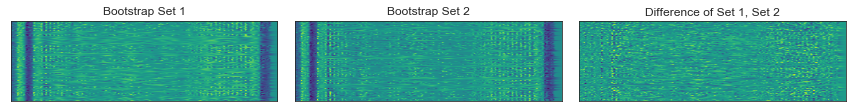

In [68]:
sns.set_style('white')

fig, ax = plt.subplots(1, 3)

ax[0].set_title('Bootstrap Set 1')
ax[0].imshow(mB1_mu, cmap = 'viridis')

ax[1].set_title('Bootstrap Set 2')
ax[1].imshow(mB2_mu, cmap = 'viridis')

ax[2].set_title('Difference of Set 1, Set 2')
ax[2].imshow(mB1_mu - mB2_mu, cmap = 'viridis')

for itx in range(3):
    ax[itx].set_xticklabels([]);
    ax[itx].set_yticklabels([]);
    
fig.set_size_inches(12, 3)
plt.tight_layout()

In [69]:
from scipy.stats import percentileofscore

def calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma, sigma = 3):
    mask = n_sigma < 3
    p_ = percentileofscore(
        n_blob_bootstrap[:, mask][:, -1], 
        n_blob_inner[mask][-1]
    )

    return p_

calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma)

89.7

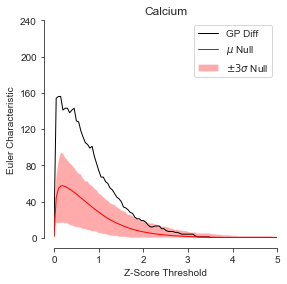

In [70]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

plt.title('Calcium', fontsize = 12)

ax.plot(n_sigma, n_blob_inner, color = 'k', linewidth = 1, clip_on = True, label = 'GP Diff')
ax.plot(n_sigma, n_blob_bootstrap.mean(axis = 0), color = 'r', linewidth = 1, label = '$\mu$ Null');

ax.fill_between(
    n_sigma, 
    np.percentile(n_blob_bootstrap, 0.3, axis = 0), 
    np.percentile(n_blob_bootstrap, 99.7, axis = 0),
    facecolor = 'r', alpha = 0.33, clip_on = True,
    label = '$\u00B13\sigma$ Null'
)

plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(0, 280, 40))
ax.set_xlim(0, 5)
ax.set_ylim(0, 240)
plt.legend()

sns.despine(ax = ax, offset = 10)
fig.set_size_inches(4, 4)

plt.savefig(directories['figs'] + 'bootstrap/' + 'calcium-bootstrap.svg', dpi = 300)

Classical Comparison

In [71]:
# path = '/gpfs01/euler/data/User/lrogerson/imaging_probabilistic/data/'
# file = 'SMP_M1_RR2_BC2_ChirpI.h5'

local_traces = data_linear['Snippets0'][:16515, :, 0]
global_traces = data_linear['Snippets0'][16516:, :, 0]

local_mean = local_traces.mean(axis = 1)
global_mean = global_traces.mean(axis = 1)

local_std = local_traces.std(axis = 1)
global_std = global_traces.std(axis = 1)

trace_times = data_linear['SnippetsTimes0'][:16515, 0, 0]
trace_times -= trace_times.min()

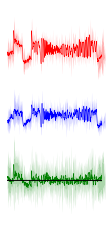

In [72]:
fig, ax = plt.subplots(1)

offset = 18

ax.plot(trace_times, local_mean + 2 * offset, color = 'r', linewidth = 0.5)
ax.fill_between(trace_times, local_mean - 3 * local_std + 2 * offset,  local_mean + 3 * local_std + 2 * offset,
                facecolor = 'r', alpha = 0.33, clip_on = False)

ax.plot(trace_times, global_mean + offset, color = 'b', linewidth = 0.5)
ax.fill_between(trace_times, global_mean - 3 * global_std + offset,  global_mean + 3 * global_std + offset, 
                facecolor = 'b', alpha = 0.33, clip_on = False)

ax.plot(trace_times, local_mean - global_mean , color = 'g', linewidth = 0.5)
ax.plot(x_predict, np.zeros(x_predict.shape), color = 'k', linewidth = 1)

ax.fill_between(trace_times, 
                local_mean - global_mean - 3 * (local_std + global_std),  
                local_mean - global_mean + 3 * (local_std + global_std), 
                facecolor = 'g', alpha = 0.33, clip_on = False)

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

ax.set_xlim(0, 32)

# plt.xticks([0, 8, 16, 24, 32])
plt.tick_params(axis = 'both', which = 'major', labelsize = 'medium')
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, bottom = True, ax = ax, offset = 10)

fig.set_size_inches(1.7, 4)

plt.savefig(directories['figs'] + 'warping/' + 'classical_diff.pdf', dpi = 300)

In [73]:
n_blob_inner = np.zeros(n_sigma.shape[0])

for itx, sigma in enumerate(n_sigma):
    # Compute EC
    upper, lower = compute_bounds(local_mean - global_mean, local_std + global_std, n_sigma = sigma)
    ax.fill_between(trace_times, upper, lower, facecolor = '#1a9850', alpha = 0.33)

    diff_mask = (upper < 0) | (lower > 0)
    
    n_blob_inner[itx] = np.unique(np.hstack(label(diff_mask)[0])).max()

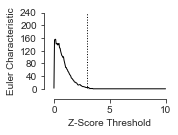

In [74]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

ax.plot(n_sigma, n_blob_inner, color = 'k', label = 'Latent', linewidth = 1, clip_on = False)
ax.plot(np.ones(240) * 3, np.arange(240), color = 'k', linewidth = 1, linestyle = ':')

sigma_mask = n_sigma > 3
ax.fill_between(
    n_sigma[sigma_mask], 
    np.zeros(n_sigma[sigma_mask].shape), 
    n_blob_inner[sigma_mask],
    facecolor = 'k', 
    alpha = 0.66,
    clip_on = False
)

ax.set_xlim(0, 10)
ax.set_ylim(0, 240)
plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 5))
plt.yticks(np.arange(0, 280, 40))

sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2, 1.4)

plt.savefig(directories['figs'] + 'warping/' + 'classical_EC.svg', dpi = 300)

In [75]:
y_pool = np.hstack([local_traces, global_traces])
y_sig_pool = np.hstack([local_std, global_std])
x_new_pool = np.hstack([trace_times, trace_times])

n_blob_out = []

n_bootstrap = 500

array_shape = [n_bootstrap, 16515]
mB1_mu, mB1_sig = np.zeros(array_shape), np.zeros(array_shape)
mB2_mu, mB2_sig = np.zeros(array_shape), np.zeros(array_shape)

for itx in tqdm.tqdm(range(n_bootstrap)):
    np.random.seed(itx)

    all_boot_samples = np.random.choice(y_pool.shape[1], y_pool.shape[1], replace = False)
    n_samples = y_pool.shape[1] // 2

    B1_samples = all_boot_samples[:n_samples]
    B2_samples = all_boot_samples[n_samples:]

    # Bootstrap 1
    mB1_mu[itx, :] = y_pool[:, B1_samples].mean(axis = 1)
    mB1_sig[itx, :] = y_pool[:, B1_samples].std(axis = 1)

    # Bootstrap 2
    mB2_mu[itx, :] = y_pool[:, B2_samples].mean(axis = 1)
    mB2_sig[itx, :] = y_pool[:, B2_samples].std(axis = 1)

n_blob_bootstrap = np.zeros([n_bootstrap, n_sigma.shape[0]])

for ity in tqdm.tqdm(range(n_bootstrap)):
    for itx, sigma in enumerate(n_sigma):
        upper, lower = compute_bounds(mB1_mu[ity, :] - mB2_mu[ity, :], mB1_sig[ity, :] + mB2_sig[ity, :], n_sigma = sigma)

        diff_mask = (upper < 0) | (lower > 0)

        n_blob_bootstrap[ity, itx] = np.unique(np.hstack(label(diff_mask)[0])).max()



  0%|          | 0/500 [00:00<?, ?it/s]

 20%|█▉        | 99/500 [00:00<00:00, 989.04it/s]

 39%|███▉      | 195/500 [00:00<00:00, 977.58it/s]

 58%|█████▊    | 292/500 [00:00<00:00, 972.85it/s]

 78%|███████▊  | 389/500 [00:00<00:00, 970.63it/s]

 97%|█████████▋| 486/500 [00:00<00:00, 967.77it/s]

100%|██████████| 500/500 [00:00<00:00, 958.65it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:20<2:53:13, 20.83s/it]

  0%|          | 2/500 [00:42<2:54:54, 21.07s/it]

  1%|          | 3/500 [01:06<3:01:46, 21.94s/it]

  1%|          | 4/500 [01:26<2:57:25, 21.46s/it]

  1%|          | 5/500 [01:48<2:57:12, 21.48s/it]

  1%|          | 6/500 [02:08<2:54:05, 21.15s/it]

  1%|▏         | 7/500 [02:28<2:50:36, 20.76s/it]

  2%|▏         | 8/500 [02:49<2:50:14, 20.76s/it]

  2%|▏         | 9/500 [03:09<2:49:14, 20.68s/it]

  2%|▏         | 10/500 [03:20<2:25:24, 17.80s/it]

  2%|▏         | 11/500 [03:28<2:00:40, 14.81s/it]

  2%|▏         | 12/500 [03:36<1:43:19, 12

 27%|██▋       | 136/500 [20:44<50:15,  8.28s/it]

 27%|██▋       | 137/500 [20:52<50:10,  8.29s/it]

 28%|██▊       | 138/500 [21:00<50:01,  8.29s/it]

 28%|██▊       | 139/500 [21:08<49:57,  8.30s/it]

 28%|██▊       | 140/500 [21:17<49:48,  8.30s/it]

 28%|██▊       | 141/500 [21:25<49:41,  8.31s/it]

 28%|██▊       | 142/500 [21:33<49:29,  8.30s/it]

 29%|██▊       | 143/500 [21:42<49:26,  8.31s/it]

 29%|██▉       | 144/500 [21:50<48:30,  8.18s/it]

 29%|██▉       | 145/500 [21:57<47:25,  8.02s/it]

 29%|██▉       | 146/500 [22:05<46:44,  7.92s/it]

 29%|██▉       | 147/500 [22:13<46:06,  7.84s/it]

 30%|██▉       | 148/500 [22:20<45:40,  7.79s/it]

 30%|██▉       | 149/500 [22:28<45:21,  7.75s/it]

 30%|███       | 150/500 [22:36<45:04,  7.73s/it]

 30%|███       | 151/500 [22:43<44:43,  7.69s/it]

 30%|███       | 152/500 [22:51<44:35,  7.69s/it]

 31%|███       | 153/500 [22:58<44:24,  7.68s/it]

 31%|███       | 154/500 [23:06<44:11,  7.66s/it]

 31%|███       | 155/500 [23:14

 56%|█████▌    | 279/500 [40:09<30:34,  8.30s/it]

 56%|█████▌    | 280/500 [40:17<30:24,  8.29s/it]

 56%|█████▌    | 281/500 [40:26<30:16,  8.30s/it]

 56%|█████▋    | 282/500 [40:34<30:10,  8.30s/it]

 57%|█████▋    | 283/500 [40:42<30:04,  8.32s/it]

 57%|█████▋    | 284/500 [40:51<29:56,  8.32s/it]

 57%|█████▋    | 285/500 [40:59<29:49,  8.32s/it]

 57%|█████▋    | 286/500 [41:07<29:41,  8.32s/it]

 57%|█████▋    | 287/500 [41:16<29:32,  8.32s/it]

 58%|█████▊    | 288/500 [41:24<29:24,  8.32s/it]

 58%|█████▊    | 289/500 [41:32<29:15,  8.32s/it]

 58%|█████▊    | 290/500 [41:41<29:06,  8.32s/it]

 58%|█████▊    | 291/500 [41:49<28:56,  8.31s/it]

 58%|█████▊    | 292/500 [41:57<28:53,  8.33s/it]

 59%|█████▊    | 293/500 [42:06<28:42,  8.32s/it]

 59%|█████▉    | 294/500 [42:14<28:35,  8.33s/it]

 59%|█████▉    | 295/500 [42:22<28:26,  8.32s/it]

 59%|█████▉    | 296/500 [42:31<28:16,  8.32s/it]

 59%|█████▉    | 297/500 [42:39<28:09,  8.32s/it]

 60%|█████▉    | 298/500 [42:47

 84%|████████▍ | 422/500 [59:58<10:48,  8.31s/it]

 85%|████████▍ | 423/500 [1:00:06<10:40,  8.31s/it]

 85%|████████▍ | 424/500 [1:00:15<10:31,  8.31s/it]

 85%|████████▌ | 425/500 [1:00:23<10:23,  8.32s/it]

 85%|████████▌ | 426/500 [1:00:31<10:15,  8.32s/it]

 85%|████████▌ | 427/500 [1:00:40<10:06,  8.30s/it]

 86%|████████▌ | 428/500 [1:00:48<09:57,  8.30s/it]

 86%|████████▌ | 429/500 [1:00:56<09:49,  8.30s/it]

 86%|████████▌ | 430/500 [1:01:05<09:42,  8.32s/it]

 86%|████████▌ | 431/500 [1:01:13<09:33,  8.32s/it]

 86%|████████▋ | 432/500 [1:01:21<09:17,  8.20s/it]

 87%|████████▋ | 433/500 [1:01:29<08:58,  8.04s/it]

 87%|████████▋ | 434/500 [1:01:36<08:43,  7.93s/it]

 87%|████████▋ | 435/500 [1:01:44<08:30,  7.85s/it]

 87%|████████▋ | 436/500 [1:01:52<08:18,  7.80s/it]

 87%|████████▋ | 437/500 [1:01:59<08:09,  7.77s/it]

 88%|████████▊ | 438/500 [1:02:07<07:59,  7.74s/it]

 88%|████████▊ | 439/500 [1:02:15<07:50,  7.72s/it]

 88%|████████▊ | 440/500 [1:02:22<07:42,  7.71s/

In [76]:
from scipy.stats import percentileofscore

def calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma, sigma = 3):
    mask = n_sigma < 3
    p_ = percentileofscore(
        n_blob_bootstrap[:, mask][:, -1], 
        n_blob_inner[mask][-1]
    )

    return p_

calc_boot_perc(n_blob_bootstrap, n_blob_inner, n_sigma)

93.8

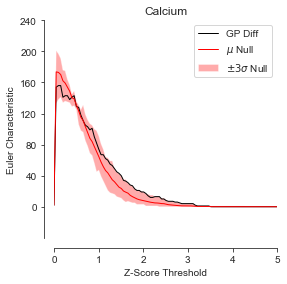

In [80]:
sns.set_style('ticks')

fig, ax = plt.subplots(1)

plt.title('Calcium', fontsize = 12)

ax.plot(n_sigma, n_blob_inner, color = 'k', linewidth = 1, clip_on = True, label = 'GP Diff')
ax.plot(n_sigma, n_blob_bootstrap.mean(axis = 0), color = 'r', linewidth = 1, label = '$\mu$ Null');

ax.fill_between(
    n_sigma, 
    np.percentile(n_blob_bootstrap, 0.3, axis = 0), 
    np.percentile(n_blob_bootstrap, 99.7, axis = 0),
    facecolor = 'r', alpha = 0.33, clip_on = True,
    label = '$\u00B13\sigma$ Null'
)

ax.fill_between(
    n_sigma, 
    np.ones(n_sigma.shape[0]) - 10, 
    np.ones(n_sigma.shape[0]) - 30, 
    where = n_blob_inner > np.percentile(n_blob_bootstrap, 99.7),
    facecolor = 'k', alpha = 0.33, clip_on = True
)

plt.tick_params(axis='both', which='major', labelsize='medium')
ax.set_xlabel('Z-Score Threshold', fontsize = 10)
ax.set_ylabel('Euler Characteristic', fontsize = 10)
plt.xticks(np.arange(0, 15, 1))
plt.yticks(np.arange(0, 280, 40))
ax.set_xlim(0, 5)
ax.set_ylim(-40, 240)
plt.legend()

sns.despine(ax = ax, offset = 10)
fig.set_size_inches(4, 4)

plt.savefig(directories['figs'] + 'bootstrap/' + 'calcium-classical-bootstrap.svg', dpi = 300)